# **Kode Program Klasifikasi Gambar + Sistem Parkir**

**1. 🔼 Upload Dataset ZIP (Secara Manual)**

*   Upload file dataset secara manual
*   Ekstrak isi ZIP
*   Cek folder hasil esktrasi





In [1]:
from google.colab import files
import zipfile
import os

# Upload file ZIP
uploaded = files.upload()

# Ekstrak file ZIP
for file in uploaded.keys():
    zip_path = file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("dataset")

# Cek folder hasil ekstraksi
os.listdir("dataset")

Saving Parkir Jenis Kendaraan.zip to Parkir Jenis Kendaraan.zip


['Parkir Jenis Kendaraan']

**2. 🧹 Preprocessing Data (Augmentasi + Normalisasi)**

*   Data Cleaning
*   Ukuran gambar model
*   Objek ImageDataGenerator
*   Data training
*   Data validation





In [32]:
import os
from PIL import Image

# Fungsi untuk menghapus gambar yang rusak atau terpotong (truncated)
def delete_truncated_images(directory):
    count_deleted = 0
    print(f"🔎 Memulai pengecekan dan penghapusan gambar rusak di: {directory}")

    # Iterasi melalui semua file di direktori dan subdirektorinya
    for root, _, files in os.walk(directory):
        for file in files:
            # Periksa apakah file adalah gambar (jpg, jpeg, png)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(root, file)
                try:
                    # Buka dan muat gambar untuk mendeteksi kerusakan
                    with Image.open(filepath) as img:
                        img.load()
                except (IOError, SyntaxError) as e:
                    # Jika gambar rusak, hapus file tersebut
                    print(f"Menghapus gambar rusak: {filepath} - Error: {e}")
                    try:
                        os.remove(filepath)
                        count_deleted += 1
                    except OSError as remove_error:
                        print(f"Error removing file {filepath}: {remove_error}")

    # Laporkan hasil penghapusan gambar
    if count_deleted == 0:
        print("✅ Tidak ada gambar rusak yang ditemukan.")
    else:
        print(f"🗑️ Total gambar rusak yang dihapus: {count_deleted}")

# Panggil fungsi pembersihan untuk direktori dataset kendaraan
dataset_directory = 'Parkir Jenis Kendaraan/Vehicles' # Pastikan path sesuai
delete_truncated_images(dataset_directory)

🔎 Memulai pengecekan dan penghapusan gambar rusak di: Parkir Jenis Kendaraan/Vehicles
✅ Tidak ada gambar rusak yang ditemukan.


**Augmentasi Data**

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menentukan ukuran gambar yang digunakan oleh model dan ukuran batch
image_size = (224, 224)
batch_size = 32

# Membuat objek ImageDataGenerator untuk preprocessing dan augmentasi data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Membuat generator data training dari folder 'Vehicles'
train_data = datagen.flow_from_directory(
    'Parkir Jenis Kendaraan/Vehicles',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Membuat generator data validasi dari folder 'Vehicles'
val_data = datagen.flow_from_directory(
    'Parkir Jenis Kendaraan/Vehicles',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3530 images belonging to 5 classes.
Found 881 images belonging to 5 classes.


**3. 🧠 Transfer Learning dengan MobileNetV2**

*   MobileNet2 (Pretrained Model)
*   Fine-Tuning (Layer Tambahan)
*   Kompilasi Model
*   Training Model (Base Model Frozen)





In [43]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load base model MobileNetV2 tanpa top (fully connected layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layer bawaan agar cepat convergence

# Tambahkan custom classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Buat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Training ulang dengan model yang lebih kuat
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.7822 - loss: 0.5751 - val_accuracy: 0.9387 - val_loss: 0.1681
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9138 - loss: 0.2030 - val_accuracy: 0.9398 - val_loss: 0.1656
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9354 - loss: 0.1645 - val_accuracy: 0.9296 - val_loss: 0.1616
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9408 - loss: 0.1515 - val_accuracy: 0.9580 - val_loss: 0.1270
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9509 - loss: 0.1252 - val_accuracy: 0.9319 - val_loss: 0.1704
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9557 - loss: 0.1126 - val_accuracy: 0.9308 - val_loss: 0.1747
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9655 - loss: 0.0931 - val_accuracy: 0.9512 - val_loss: 0.1262
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9685 - loss: 0.0923 - val_accu

**4. 🏋️‍♀️ Training Model**

In [44]:
# Unfreeze sebagian layer akhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # hanya fine-tune 30 layer terakhir
    layer.trainable = False

# Compile ulang model dengan learning rate lebih kecil
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Lanjutkan training dengan fine-tuning
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8499 - loss: 0.4331 - val_accuracy: 0.9659 - val_loss: 0.1117
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.9377 - loss: 0.1738 - val_accuracy: 0.9591 - val_loss: 0.1107
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.9415 - loss: 0.1619 - val_accuracy: 0.9557 - val_loss: 0.1174
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9502 - loss: 0.1359 - val_accuracy: 0.9478 - val_loss: 0.1274
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9608 - loss: 0.1211 - val_accuracy: 0.9694 - val_loss: 0.1010
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.9611 - loss: 0.1098 - val_accuracy: 0.9694 - val_loss: 0.1029
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.9631 - loss: 0.0998 - val_accuracy: 0.9716 - val_loss: 0.0895
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9770 - loss: 0.0809 - val_accu

**5. 📊 Evaluasi Model**

*   Prediksi data validasi
*   Confusion Matrix
*   Classification Report
*   Accuracy Score



28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step


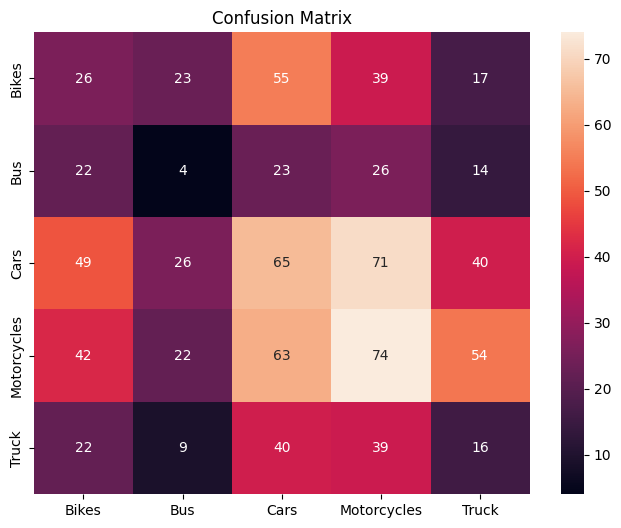

              precision    recall  f1-score   support

       Bikes       0.16      0.16      0.16       160
         Bus       0.05      0.04      0.05        89
        Cars       0.26      0.26      0.26       251
 Motorcycles       0.30      0.29      0.29       255
       Truck       0.11      0.13      0.12       126

    accuracy                           0.21       881
   macro avg       0.18      0.18      0.18       881
weighted avg       0.21      0.21      0.21       881

Accuracy Score: 21.00%


In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi di data validasi
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

# Tampilkan Confusion Matrix
cm = confusion_matrix(val_data.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(val_data.classes, y_pred, target_names=val_data.class_indices.keys()))

# Accuracy Score
accuracy = accuracy_score(val_data.classes, y_pred)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

**6. 🖼 Upload Gambar Kendaraan untuk Diuji**

In [46]:
# Uji Parkir dengan Upload Gambar Kendaraan
from tensorflow.keras.preprocessing import image
uploaded = files.upload()

Saving mobil_test.png to mobil_test.png


**7. 🅿️ Deteksi Kendaraan + Simulasi Parkir Realistis**

*   Deteksi gambar kendaraan
*   Tampilkan informasi parkir kendaraan
*   Simulasi parkir kendaraan dan pembayaran
*   Logging Data ke file CSV


In [49]:
import pandas as pd
from datetime import datetime
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files # Assuming files was imported in a previous cell

#Info parkir berdasarkan jenis kendaraan
info_parkir = {
    'Bus': {"tarif": 15000, "lantai": "1 & 2", "area": "C1–C4 & B1–B6"},
    'Cars': {"tarif": 8000, "lantai": "2 & 3", "area": "B7–A10 & A1–A6"},
    'Truck': {"tarif": 10000, "lantai": "1", "area": "C5–C8"},
    'Bikes': {"tarif": 1000, "lantai": "1", "area": "C9–C10"},
    'Motorcycles': {"tarif": 3000, "lantai": "B1 & B2", "area": "D1–D10 & E1–E10"}
}

#Deteksi gambar kendaraan & tampilkan informasi parkir
for fn in uploaded.keys():

    # Preprocessing gambar
    img = image.load_img(fn, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi jenis kendaraan
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = list(train_data.class_indices.keys())[class_index]

    # Tampilkan info hasil deteksi
    print(f"\n🔍 Jenis Kendaraan Terdeteksi: {class_label}")
    print(f"📍 Lantai: {info_parkir[class_label]['lantai']}")
    print(f"📍 Area: {info_parkir[class_label]['area']}")
    print(f"💰 Tarif Parkir: Rp{info_parkir[class_label]['tarif']}/jam")

    # Input waktu masuk & keluar
    tanggal_masuk = input("📅 Masukkan tanggal masuk (format: YYYY-MM-DD): ")
    jam_masuk = input("⏱ Masukkan waktu masuk (format: HH:MM, contoh: 08:00): ")

    tanggal_keluar = input("📅 Masukkan tanggal keluar (format: YYYY-MM-DD): ")
    jam_keluar = input("⏱ Masukkan waktu keluar (format: HH:MM, contoh: 10:15): ")

    # Hitung durasi (dalam jam)
    t1 = datetime.strptime(f"{tanggal_masuk} {jam_masuk}", "%Y-%m-%d %H:%M")
    t2 = datetime.strptime(f"{tanggal_keluar} {jam_keluar}", "%Y-%m-%d %H:%M")
    # Call the total_seconds method by adding ()
    durasi = (t2 - t1).total_seconds() / 3600
    durasi_jam = max(1, round(durasi))  # dibulatkan ke atas min 1 jam

    # Hitung total tarif parkir
    tarif_per_jam = info_parkir[class_label]['tarif']
    total = tarif_per_jam * durasi_jam

    # Output durasi & biaya parkir
    print(f"🕓 Durasi Parkir: {durasi_jam} jam")
    print(f"💸 Total Tarif: Rp{total}")

    # Proses pembayaran
    bayar = int(input("💵 Masukkan jumlah uang yang dibayar (misal 20000): "))
    kembali = bayar - total
    print(f"💳 Kembalian: Rp{kembali}")

    # Buat log dictionary ke CSV harian
    log_data = {
        "tanggal_masuk": tanggal_masuk,
        "jam_masuk": jam_masuk,
        "tanggal_keluar": tanggal_keluar,
        "jam_keluar": jam_keluar,
        "kendaraan": class_label,
        "durasi_jam": durasi_jam,
        "total_tarif": total,
        "dibayar": bayar,
        "kembalian": kembali,
        "waktu_input": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    # Konversi ke DataFrame
    df_log = pd.DataFrame([log_data])

    # Buat nama file berdasarkan tanggal masuk
    # Corrected: use 'tanggal_masuk' from log_data instead of 'tanggal'
    log_filename = f"log_parkir_{log_data['tanggal_masuk']}.csv"

    # Simpan ke file log harian
    df_log.to_csv(log_filename, mode='a', header=not os.path.exists(log_filename), index=False)

    print(f"📝 Data parkir disimpan ke {log_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

🔍 Jenis Kendaraan Terdeteksi: Cars
📍 Lantai: 2 & 3
📍 Area: B7–A10 & A1–A6
💰 Tarif Parkir: Rp8000/jam
📅 Masukkan tanggal masuk (format: YYYY-MM-DD): 2025-06-10
⏱ Masukkan waktu masuk (format: HH:MM, contoh: 08:00): 10:37
📅 Masukkan tanggal keluar (format: YYYY-MM-DD): 2025-06-10
⏱ Masukkan waktu keluar (format: HH:MM, contoh: 10:15): 16:57
🕓 Durasi Parkir: 6 jam
💸 Total Tarif: Rp48000
💵 Masukkan jumlah uang yang dibayar (misal 20000): 50000
💳 Kembalian: Rp2000
📝 Data parkir disimpan ke log_parkir_2025-06-10.csv
